In [1]:
# boiler plate
from collections import Counter
import pickle
from importlib import reload
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


import ipdb
import mytf.utils as mu

tf.enable_eager_execution()

print(tf.executing_eagerly())



True


In [ ]:
# Last trial in book 2019-07-07, I changed over to 
# "build_dataset_weighty_v2"  , which had two major changes, 
# (a) I shuffled the 47,000 training examples . So for the 47 batches, each was mixed.
# (b) the weights tensor, shape (47000,1), now added up to 1.0 for each 1000-element batch.

# But the result still looked like the losses in the loss history plot were very small. 
# So this time, I am trying something new and I am not scaling down those weights the same way.
#
# Maybe I misunderstood that part. 
# I am now using "build_dataset_weighty_v3" , which still shuffles but doesn't scale.
# Instead, the weight for each training example is just one of the class weights.

In [2]:
with open('models/2019-05-19T001217-UTC-outdata--SUBSET.pkl', 'rb') as fd:
    minidata = pickle.load(fd)

In [3]:
reload(mu)
#Hand-tuned ... 
class_weights = {0: 0.1, 1: 0.5, 2: 0.1, 3: 0.3}

training_indices = np.arange(0, minidata['x_train'].shape[0], 1)[:47000]
print('training indices...', training_indices.shape)

dataset_batches = mu.build_dataset_weighty_v3(minidata, training_indices, class_weights,
        batch_size=1000)


training indices... (47000,)
Start build v3: .. doesnt add up to 1.0
num slices 47
size_remainder,  0
Counter({3: 404, 2: 213, 0: 204, 1: 179})
weights_per_class,  tf.Tensor([0.0004902  0.0027933  0.00046948 0.00074257], shape=(4,), dtype=float32)
252.40000000000003
Counter({3: 417, 0: 236, 2: 202, 1: 145})
weights_per_class,  tf.Tensor([0.00042373 0.00344828 0.00049505 0.00071942], shape=(4,), dtype=float32)
241.39999999999998
Counter({3: 380, 0: 232, 2: 209, 1: 179})
weights_per_class,  tf.Tensor([0.00043103 0.0027933  0.00047847 0.00078947], shape=(4,), dtype=float32)
247.5999999999997
Counter({3: 429, 2: 219, 0: 199, 1: 153})
weights_per_class,  tf.Tensor([0.00050251 0.00326797 0.00045662 0.0006993 ], shape=(4,), dtype=float32)
247.00000000000028
Counter({3: 384, 2: 232, 0: 218, 1: 166})
weights_per_class,  tf.Tensor([0.00045872 0.00301205 0.00043103 0.00078125], shape=(4,), dtype=float32)
243.20000000000002
Counter({3: 406, 0: 233, 2: 209, 1: 152})
weights_per_class,  tf.Tensor([0

In [4]:
# okay... now try use that ..
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,   dropout=0.2, recurrent_dropout=0.2,
                batch_input_shape=(None, 256, 1), 
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)
])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:

%time loss_history = mu.do_train(model, dataset_batches)


Instructions for updating:
Use tf.cast instead.
CPU times: user 5min 26s, sys: 2min 25s, total: 7min 51s
Wall time: 4min 59s


Text(0, 0.5, 'Loss [entropy]')

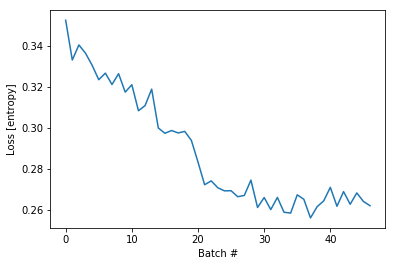

In [6]:
# Loss still pretty small. but Since this is the first time I shuffled, 
# the loss history looks really much more interesting.
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [7]:
print(minidata['x_train'].shape)
train_subset = np.random.choice(np.arange(0, minidata['x_train'].shape[0], 1),
                               10000, replace=False)
print('subset, ', len(train_subset))

# First make sure this random training subset covers all four classes.
Counter(np.argmax(minidata['y_train'][train_subset, :], axis=1))




(47689, 256, 1)
subset,  10000


Counter({3: 4127, 1: 1614, 0: 2073, 2: 2186})

In [8]:
%time y_pred_train = model(tf.convert_to_tensor(minidata['x_train'][train_subset], dtype=tf.float32))

CPU times: user 27.3 s, sys: 8.76 s, total: 36.1 s
Wall time: 10.7 s


In [9]:
# confusion... 
tf.confusion_matrix(
    np.argmax(minidata['y_train'][train_subset, :], axis=1),  # labels

    np.argmax(y_pred_train, axis=1), # predictions
    num_classes=4)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


<tf.Tensor: id=3973524, shape=(4, 4), dtype=int32, numpy=
array([[   0,    0,    0, 2073],
       [   0,  839,    0,  775],
       [   0,    0,    0, 2186],
       [   0, 1657,    0, 2470]], dtype=int32)>

In [10]:
print(class_weights)

{0: 0.1, 1: 0.5, 2: 0.1, 3: 0.3}


In [ ]:
# Okay well so I for sure misunderstood the requirement for the weights. 
# They don't need to add  up to 1.0
# - In the previous attempt, all the predictions were on class=1, which I have the highest weight
#   for.
# - This time around, all the predictions went to class=1 and class=3 , which have the 
#   top two highest weights.
# - Thing is that I had already used those weights to build the training dataset in the 
#   first place. 
# 
# But  I know from notebook "2019-07-06-today", using no weights (also no shuffling), 
#  skewed the train predictions to all go to class=3 , which is the class with 2x examples
#  compared to any other class.

In [12]:
Counter(np.argmax(minidata['y_train'][training_indices], axis=1))

Counter({0: 10000, 1: 7689, 2: 10000, 3: 19311})

In [14]:
counts = dict(Counter(np.argmax(minidata['y_train'][training_indices], axis=1)))

print('training set counts, ', counts)

{k:class_weights[k]*counts[k] for k in [0,1,2,3]} 

training set counts,  {0: 10000, 1: 7689, 2: 10000, 3: 19311}


{0: 1000.0, 1: 3844.5, 2: 1000.0, 3: 5793.3}

In [19]:
# Going to adjust that to be more even...
class_weights = {0: 1.0, 1: 1.3, 2: 1.0, 3: 0.55}
print({k:class_weights[k]*counts[k] for k in [0,1,2,3]})


{0: 10000.0, 1: 9995.7, 2: 10000.0, 3: 10621.050000000001}
